In [10]:
import numpy as np

# create samples
samples = []
filename = '../data/obj_pose-laser-radar-synthetic-input.txt'
readfile = open(filename,'r')


In [11]:
x = np.array([1., 1., 0., 0.])

x_all = np.empty((4,0))
x_all = np.hstack((x_all,x.reshape(-1,1)))

P = np.array([[1, 0, 0, 0],
             [0, 1, 0, 0],
             [0, 0, 100, 0],
             [0, 0, 0, 100]], dtype = float)

p00 = np.array([P[0, 0]])
p11 = np.array([P[1, 1]])
p22 = np.array([P[2, 2]])
p33 = np.array([P[3, 3]])

R_lidar = np.array([[0.0225, 0], [0, 0.0225]])
R_radar = np.array([[0.09, 0, 0], [0, 0.0009, 0], [0, 0, 0.09]])

H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype = float) # H_lidar

In [12]:
# Calculate Jacobian

def CalculateJacobian(x):

    H = np.zeros((3,4), dtype=float) # H_radar

    px = float(x[0])
    py = float(x[1])
    vx = float(x[2])
    vy = float(x[3])

    den1 = float(np.sqrt(px*px + py*py))
    den2 = float(px*px + py*py)
    den3 = float(den1*den2)

    if np.abs(den1) < 1E-5:
        return H
    
    H[0,0] = px/den1
    H[0,1] = py/den1
    H[0,2] = 0.0
    H[0,3] = 0.0
    H[1,0] = -py/den2
    H[1,1] = px/den2
    H[1,2] = 0.0
    H[1,3] = 0.0
    H[2,0] = py*(vx*py - vy*px)/den3
    H[2,1] = px*(vy*px - vx*py)/den3
    H[2,2] = px/den1
    H[2,3] = py/den1

    return H

In [13]:
def CalculateRSME(xmeas, xtruth):
        
    residual = xmeas - xtruth    
    residual_sq = residual*residual
        
    if xmeas.ndim == 1:
        rmse = np.sqrt(residual_sq)
    else:
        rc = residual.shape
        c = rc[1]
        rmse = np.zeros((4,), dtype=float)
        for k in range(c):
            rmse = rmse + residual_sq[:,k]
        rmse = rmse/c
        rmse = np.sqrt(rmse)
        
    rmse = rmse.reshape(-1,1)
    return rmse

In [14]:
a = np.array([[1,2,21],[3,4,41],[5,6,61],[7,8,81]])
b = a + 0.1

c = np.array([1,2,3,4])
d = c + 0.1

rmse = CalculateRSME(a,b)
print(rmse)

#rmse = CalculateRSME(c,d)
#print(rmse)

[[0.1]
 [0.1]
 [0.1]
 [0.1]]


In [15]:
a = np.array([1,2,3])
a = a.reshape(-1,1)
b = np.empty((3,0))
c = np.hstack((b,a))
c

array([[1.],
       [2.],
       [3.]])

In [16]:
# Lidar measurement

n = len(open(filename).readlines(  ))

is_init = False

timestamp = []
x_groundtruth = []
y_groundtruth = []
vx_groundtruth = []
vy_groundtruth = []
ground_truth = []
rmse_all = np.empty((4,0))

for k in range(n):
    line = readfile.readline()
    words = line.split('\t')
    
    if words[0] == 'L': 
        
        x_measured = float(words[1])
        y_measured = float(words[2])
        t = float(words[3])
        xg = float(words[4])
        yg = float(words[5])
        vxg = float(words[6])
        vyg = float(words[7])
        
        print(np.array([xg, yg, vxg, vyg]))
        
        timestamp = np.hstack((timestamp, t))
        x_groundtruth = np.hstack((x_groundtruth, xg))
        y_groundtruth = np.hstack((y_groundtruth, yg))
        vx_groundtruth = np.hstack((vx_groundtruth, vxg))
        vy_groundtruth = np.hstack((vy_groundtruth, vyg))
        
        z = np.array([x_measured, y_measured])
    
        t_current = timestamp[k]/1E6
        if is_init == False:
            t_previous = t_current
            x[0] = x_measured
            x[1] = y_measured
            x[2] = 0
            x[3] = 0
            is_init = True

        dt = t_current - t_previous   
        t_previous = t_current
        
        F = np.array(
            [[1, 0, dt, 0],
             [0, 1, 0, dt],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])
        
        dt4 = dt*dt*dt*dt;
        dt3 = dt*dt*dt;
        dt2 = dt*dt;
        sx2 = 9;
        sy2 = 9;

        Q = [[dt4/4*sx2,      0,    dt3/2*sx2,  0],
             [0,    dt4/4*sy2,   0,     dt3/2*sy2],
             [dt3/2*sx2,      0,    dt2*sx2,    0],  
             [0,    dt3/2*sy2,   0,     dt2*sy2]]       
        
        
        # Prediction
        x = np.matmul(F,x)
        P = np.matmul(np.matmul(F, P), F.T)  + Q
        
        # Update
        y = z - np.matmul(H, x)

        H_t = H.T
        S = np.matmul(np.matmul(H, P), H_t) + R_lidar
        S_i = np.linalg.inv(S)
        K =  np.matmul(np.matmul(P, H_t), S_i)

        x = x + np.matmul(K, y);
        P = np.matmul((np.eye(4) - np.matmul(K, H)), P)
        
        # store data
        x_all = np.hstack((x_all, x.reshape(-1,1)))
        
        p00 = np.hstack((p00, P[0, 0]))
        p11 = np.hstack((p11, P[1, 1]))
        p22 = np.hstack((p22, P[2, 2]))
        p33 = np.hstack((p33, P[3, 3]))
                
        ground_truth = np.vstack((x_groundtruth, y_groundtruth))
        ground_truth = np.vstack((ground_truth, vx_groundtruth))
        ground_truth = np.vstack((ground_truth, vy_groundtruth))
                
        # calculate rmse   
        rmse = CalculateRSME(x_all[:,:-1], ground_truth)
        
        rmse_all = np.hstack((rmse_all, rmse))

    if words[0] == 'R':
        
        radar_rho_measured = float(words[1])
        radar_phi_measured = float(words[2])
        radar_rhodot_measured = float(words[3])
        
        t = float(words[4])
        xg = float(words[5])
        yg = float(words[6])
        vxg = float(words[7])
        vyg = float(words[8])
        
        timestamp = np.hstack((timestamp, t))
        x_groundtruth = np.hstack((x_groundtruth, xg))
        y_groundtruth = np.hstack((y_groundtruth, yg))
        vx_groundtruth = np.hstack((vx_groundtruth, vxg))
        vy_groundtruth = np.hstack((vy_groundtruth, vyg))
        
        z = np.array([radar_rho_measured, radar_phi_measured, radar_rhodot_measured])
                        
        t_current = timestamp[k]/1E6
        if is_init == False:
            t_previous = t_current
            is_init = True
            x[0] = radar_rho_measured*np.cos(radar_phi_measured)
            x[1] = radar_rho_measured*np.sin(radar_phi_measured)
            x[2] = radar_rhodot_measured*np.cos(radar_phi_measured)
            x[3] = radar_rhodot_measured*np.sin(radar_phi_measured)
        
        dt = t_current - t_previous   
        t_previous = t_current
        
        F = np.array(
            [[1, 0, dt, 0],
             [0, 1, 0, dt],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])
        
        dt4 = dt*dt*dt*dt;
        dt3 = dt*dt*dt;
        dt2 = dt*dt;
        sx2 = 9;
        sy2 = 9;

        Q = [[dt4/4*sx2,      0,    dt3/2*sx2,  0],
             [0,    dt4/4*sy2,   0,     dt3/2*sy2],
             [dt3/2*sx2,      0,    dt2*sx2,    0],  
             [0,    dt3/2*sy2,   0,     dt2*sy2]]
        
        # Prediction
        x = np.matmul(F,x)
        P = np.matmul( np.matmul(F, P), F.T)  + Q
                                        
        print('radar-Q')
        print(Q)
        
        # Update
        Hj = np.zeros((3,4), dtype=float) 
        Hj = CalculateJacobian(x)
        
        px = float(x[0])
        py = float(x[1])
        vx = float(x[2])
        vy = float(x[3])
        
        rho = np.sqrt( px*px + py*py )
        if rho!= 0:
            hx = np.array([rho, np.arctan2( py, px ), ( px*vx + py*vy )/rho])
        else:
            hx = np.array([rho, np.arctan2( py, px ), 0])
            
        y = z - hx
          
        if ( y[1] > np.pi ):
            y[1] -= 2*np.pi
        if ( y[1] < -np.pi ):
            y[1] += 2*np.pi

        Hj_t = Hj.T

        
        S = np.matmul(np.matmul(Hj, P), Hj_t) + R_radar
        S_i = np.linalg.inv(S)
        K =  np.matmul(np.matmul(P, Hj_t), S_i)
        
        x = x + np.matmul(K, y);
        P = np.matmul((np.eye(4) - np.matmul(K, Hj)), P)    
                        

        # store data
        
        x_all = np.hstack((x_all, x.reshape(-1,1)))        

        p00 = np.hstack((p00, P[0, 0]))
        p11 = np.hstack((p11, P[1, 1]))
        p22 = np.hstack((p22, P[2, 2]))
        p33 = np.hstack((p33, P[3, 3]))
                           
        ground_truth = np.vstack((x_groundtruth, y_groundtruth))
        ground_truth = np.vstack((ground_truth, vx_groundtruth))
        ground_truth = np.vstack((ground_truth, vy_groundtruth))
               
        # calculate rmse
        rmse = CalculateRSME(x_all[:,:-1], ground_truth)
        rmse_all = np.hstack((rmse_all, rmse))
                

[0.6      0.6      5.199937 0.      ]
radar-Q
[[1.4062446355896443e-05, 0, 0.0005624983906761259, 0], [0, 1.4062446355896443e-05, 0, 0.0005624983906761259], [0.0005624983906761259, 0, 0.022499957084676225, 0], [0, 0.0005624983906761259, 0, 0.022499957084676225]]
[1.119984   0.6002246  5.199429   0.00538996]
radar-Q
[[1.4062714577949013e-05, 0, 0.0005625064373261921, 0], [0, 1.4062714577949013e-05, 0, 0.0005625064373261921], [0.0005625064373261921, 0, 0.02250017166170437, 0], [0, 0.0005625064373261921, 0, 0.02250017166170437]]
[1.639904  0.6013473 5.198392  0.0179597]
radar-Q
[[1.4062446355896443e-05, 0, 0.0005624983906761259, 0], [0, 1.4062446355896443e-05, 0, 0.0005624983906761259], [0.0005624983906761259, 0, 0.022499957084676225, 0], [0, 0.0005624983906761259, 0, 0.022499957084676225]]
[2.159704   0.6040855  5.196776   0.03769324]
radar-Q
[[1.4062446355896443e-05, 0, 0.0005624983906761259, 0], [0, 1.4062446355896443e-05, 0, 0.0005624983906761259], [0.0005624983906761259, 0, 0.0224999

radar-Q
[[1.4062446355896443e-05, 0, 0.0005624983906761259, 0], [0, 1.4062446355896443e-05, 0, 0.0005624983906761259], [0.0005624983906761259, 0, 0.022499957084676225, 0], [0, 0.0005624983906761259, 0, 0.022499957084676225]]
[-19.84305   -9.360706  -4.704871   1.140799]
radar-Q
[[1.4062446355896443e-05, 0, 0.0005624983906761259, 0], [0, 1.4062446355896443e-05, 0, 0.0005624983906761259], [0.0005624983906761259, 0, 0.022499957084676225, 0], [0, 0.0005624983906761259, 0, 0.022499957084676225]]
[-20.31021   -9.234455  -4.63328    1.383034]
radar-Q
[[1.4062446355896443e-05, 0, 0.0005624983906761259, 0], [0, 1.4062446355896443e-05, 0, 0.0005624983906761259], [0.0005624983906761259, 0, 0.022499957084676225, 0], [0, 0.0005624983906761259, 0, 0.022499957084676225]]
[-20.76955   -9.084085  -4.548955   1.622957]
radar-Q
[[1.4062714577949013e-05, 0, 0.0005625064373261921, 0], [0, 1.4062714577949013e-05, 0, 0.0005625064373261921], [0.0005625064373261921, 0, 0.02250017166170437, 0], [0, 0.0005625064

In [17]:
#print(rmse_all.shape)
#print(rmse_all)
#print(time)

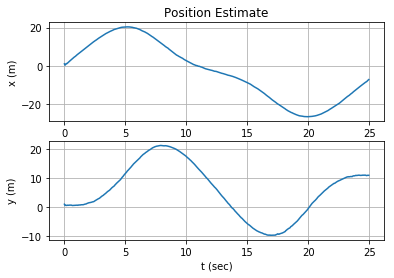

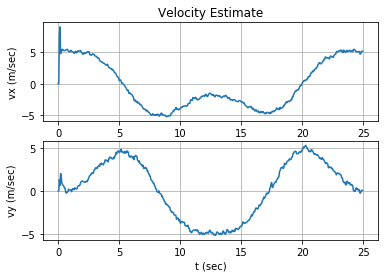

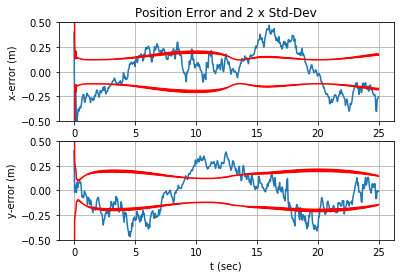

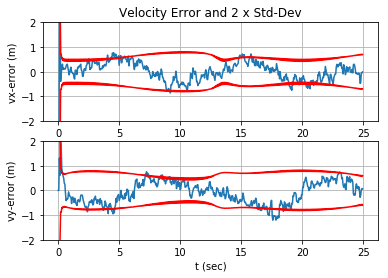

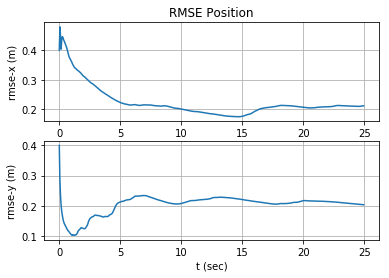

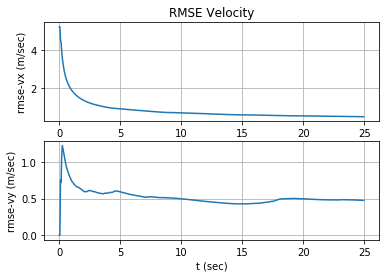

In [18]:
# Radar measurement

import matplotlib.pyplot as plt

time = (timestamp - timestamp[0])/1E6

plt.figure(1)
plt.subplot(211)
plt.plot(time, x_all[0,:-1])
plt.ylabel('x (m)')
plt.grid()
plt.title('Position Estimate')
plt.subplot(212)
plt.plot(time, x_all[1,:-1])
plt.ylabel('y (m)')
plt.xlabel('t (sec)')
plt.grid()

plt.figure(2)
plt.subplot(211)
plt.plot(time, x_all[2,:-1])
plt.ylabel('vx (m/sec)')
plt.grid()
plt.title('Velocity Estimate')
plt.subplot(212)
plt.plot(time, x_all[3,:-1])
plt.ylabel('vy (m/sec)')
plt.xlabel('t (sec)')
plt.grid()


plt.figure(3)
plt.subplot(211)
plt.plot(time, x_all[0,:-1] - x_groundtruth, \
        time, 2*np.sqrt(p00[:-1]), 'r',
        time, -2*np.sqrt(p00[:-1]), 'r')
plt.ylabel('x-error (m)')
plt.ylim([-0.5,0.5])
plt.grid()
plt.title('Position Error and 2 x Std-Dev')
plt.subplot(212)
plt.plot(time, x_all[1,:-1] - y_groundtruth, \
        time, 2*np.sqrt(p11[:-1]), 'r',
        time, -2*np.sqrt(p11[:-1]), 'r')
plt.ylabel('y-error (m)')
plt.xlabel('t (sec)')
plt.ylim([-0.5,0.5])
plt.grid()


plt.figure(4)
plt.subplot(211)
plt.plot(time, x_all[2,:-1] - vx_groundtruth, \
        time, 2*np.sqrt(p22[:-1]), 'r',
        time, -2*np.sqrt(p22[:-1]), 'r')
plt.ylabel('vx-error (m)')
plt.ylim([-2,2])
plt.grid()
plt.title('Velocity Error and 2 x Std-Dev')
plt.subplot(212)
plt.plot(time, x_all[3,:-1] - vy_groundtruth, \
        time, 2*np.sqrt(p33[:-1]), 'r',
        time, -2*np.sqrt(p33[:-1]), 'r')
plt.ylabel('vy-error (m)')
plt.xlabel('t (sec)')
plt.ylim([-2,2])
plt.grid()


plt.figure(5)
plt.subplot(211)
plt.plot(time, rmse_all[0,:])
plt.ylabel('rmse-x (m)')
plt.grid()
plt.title('RMSE Position')
plt.subplot(212)
plt.plot(time, rmse_all[1,:])
plt.ylabel('rmse-y (m)')
plt.xlabel('t (sec)')
plt.grid()

plt.figure(6)
plt.subplot(211)
plt.plot(time, rmse_all[2,:])
plt.ylabel('rmse-vx (m/sec)')
plt.grid()
plt.title('RMSE Velocity')
plt.subplot(212)
plt.plot(time, rmse_all[3,:])
plt.ylabel('rmse-vy (m/sec)')
plt.xlabel('t (sec)')
plt.grid()


